In [370]:
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns

In [4]:
#sqlite 設定
con = sqlite3.connect('../../data/race_data_set.db') # データベースに接続する
cur = con.cursor()

In [5]:
sql_result = "select * from race_result"
sql_info   = "select * from race_info"
sql_pay = "select * from race_pay"

df_r = pd.read_sql_query(sql=sql_result,con=con)
df_i = pd.read_sql_query(sql=sql_info,con=con)
df_p = pd.read_sql_query(sql=sql_pay,con=con)


In [6]:
df_r.head()

,race_id,tyaku,wakuban,umaban,horse_id,horse_name,horse_sex,horse_years,jockey,kinryo,odds,popular,time,last3f,p1,p2,p3,p4,horse_weight,dif_horse_weight
0,202003010602,1,2,3,2017104234,スズノヤマト,牡,3,勝浦正樹,56.0,10.1,5,69.9,34.6,0,0,8,7,460.0,-4.0
1,202003010602,2,3,5,2017100246,シゲルフォボス,牡,3,酒井学,56.0,7.9,4,69.9,35.6,0,0,1,1,484.0,6.0
2,202003010602,3,5,9,2017103278,シアープレジャー,牝,3,西村淳也,53.0,16.1,7,70.0,35.3,0,0,4,2,410.0,4.0
3,202003010602,4,5,10,2017100458,エーティーロンドン,牡,3,団野大成,54.0,7.7,3,70.2,35.8,0,0,2,2,512.0,4.0
4,202003010602,5,6,12,2017101605,ゲームアルアル,牡,3,丸田恭介,56.0,17.1,8,70.2,34.7,0,0,11,9,480.0,4.0


In [9]:
df_i.head(3)

,race_id,race_num,race_name,race_date,race_rank1,race_rank2,distance,kind,condition,place,horse_count,lap_time,conner1,conner2,conner3,conner4
0,202003010602,2,3歳未勝利,2020-04-26,3歳,未勝利,1200,芝,良,福島,16,12.3-10.7-11.3-11.7-11.4-12.5,None,None,"5(10,14)(4,9)(2,7)-(3,13,15)(11,12)16(1,8)=6","5(10,9,14)(4,7)(2,3)-(12,13,15)-11,16,8-1 6"
1,202003010603,3,3歳未勝利,2020-04-26,3歳,未勝利,1700,ダ,良,福島,15,7.3-11.3-11.9-12.8-13.1-12.9-13.3-13.0-13.3,"(*2,5)9(4,12,15)14(3,11)-(6,7)(8,13)(1,10)","2,5(4,9)12(3,15)14,11(6,7)-8,13,1,10","2,9(4,5,12,7)(15,11,1)14(6,10)(3,8)=13","(2,9,*7)(4,1)12-5(15,6,11,10)8,3,14-13"
2,202003010605,5,3歳未勝利,2020-04-26,3歳,未勝利,1200,芝,良,福島,16,12.6-10.9-11.2-12.0-11.9-12.5,None,None,"1,11(4,5)(2,16)3(6,10)(7,12)(8,13)(9,15)-14","1(11,5)(2,16)4(3,6,10)(7,12)8,13,9,15-14"


In [156]:
df_p.head(2)

,race_id,indicator,horse_1,horse_2,horse_3,pay
0,202003010602,tan,3,None,None,1010
1,202003010602,fuku,3,None,None,250


In [146]:
#レースの配当金の平均
df_p_ren3 = df_p[df_p["indicator"]=="sanfuku"]
print("全体平均",np.mean(df_p_ren3.pay))
#各カテゴリごとの平均
df_p_ren3 = df_p_ren3.merge(df_i,on='race_id',how='inner')
#開催場毎の平均
pay_data = df_p_ren3.pivot_table(index=["place","kind","distance"],values='pay',aggfunc=[np.mean,np.median,np.std, len],fill_value=0).reset_index()
pay_data.columns = ["place","kind","distance","pay_mean","pay_mid","pay_std","race_count"]
pay_data_mean=pay_data.sort_values(by='pay_mean', ascending=False)

c =0
for i in pay_data_mean.values:
    if i[6] > 50:
        print("{} {}{}m  平均{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[3]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_mid=pay_data.sort_values(by='pay_mid', ascending=False)
c=0
for i in pay_data_mid.values:
    if i[6] > 50:
        print("{} {}{}m  中央値{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[4]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_std=pay_data.sort_values(by='pay_std', ascending=True)
c=0
for i in pay_data_std.values:
    if i[6] > 50:
        print("{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break

全体平均 24509.04499781564
小倉 芝1200m  平均44140.97046413502 分散97286.73084998761 レース数237
中京 芝1200m  平均40855.13513513513 分散115574.90634220254 レース数74
東京 ダ2100m  平均40481.13924050633 分散181195.66341239575 レース数158
中京 ダ1800m  平均40473.14410480349 分散364875.24394092354 レース数229
新潟 芝1600m  平均38937.74193548387 分散171803.51032139006 レース数62
阪神 ダ1400m  平均35677.36654804271 分散115592.54239184975 レース数281
京都 ダ1400m  平均34491.25925925926 分散98896.18219468063 レース数270
中山 ダ1800m  平均33517.14022140222 分散125650.72043478572 レース数542
福島 芝1800m  平均33384.782608695656 分散76650.03952570984 レース数92
東京 ダ1300m  平均32449.59595959596 分散93796.83056652223 レース数99
京都 芝1200m  平均31215.670103092783 分散68618.08917702897 レース数97
阪神 ダ1200m  平均30811.626794258373 分散114506.89248752019 レース数209
京都 芝1400m  平均29988.51485148515 分散77628.6498064489 レース数101
小倉 ダ1700m  平均28823.463035019457 分散94096.86926949225 レース数257
京都 ダ1200m  平均28161.181102362203 分散58010.17920235724 レース数254
--------------------------------------------------------------------------------------

In [155]:
df_p_ren3["year"] = pd.to_datetime(df_p_ren3["race_date"],format='%Y-%m-%d').dt.year
pay_data = df_p_ren3.pivot_table(index=["year","place","kind","distance"],values='pay',aggfunc=[np.mean,np.median,np.std, len],fill_value=0).reset_index()
pay_data.columns = ["year","place","kind","distance","pay_mean","pay_mid","pay_std","race_count"]
pay_data_mean=pay_data.sort_values(by='pay_mean', ascending=False)

c =0
for i in pay_data_mean.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_mid=pay_data.sort_values(by='pay_mid', ascending=False)
c=0
for i in pay_data_mid.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_std=pay_data.sort_values(by='pay_std', ascending=True)
c=0
for i in pay_data_std.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break

2017:中京 ダ1800m  平均117570.55555555556/中央値5475 分散748184.7383851904 レース数54
2019:阪神 ダ1400m  平均65167.666666666664/中央値6720 分散186128.3085816884 レース数60
2017:中山 ダ1800m  平均59755.267857142855/中央値6905 分散234300.61285389622 レース数112
2017:京都 ダ1400m  平均58440.16949152543/中央値8560 分散171478.36516288665 レース数59
2017:小倉 ダ1700m  平均45210.181818181816/中央値5640 分散158078.67868144024 レース数55
2017:京都 ダ1800m  平均38966.52631578947/中央値6600 分散116324.33991626203 レース数95
2018:新潟 ダ1800m  平均38108.813559322036/中央値7440 分散81854.25477292038 レース数59
2019:阪神 ダ1800m  平均37864.395604395606/中央値3870 分散167164.05591320424 レース数91
2016:京都 ダ1400m  平均37286.031746031746/中央値6280 分散84625.59661084173 レース数63
2018:中山 ダ1800m  平均36815.625/中央値6550 分散98197.69885729052 レース数112
2018:京都 ダ1200m  平均35225.27272727273/中央値8360 分散80032.23433588877 レース数55
2017:中山 ダ1200m  平均30493.43137254902/中央値7820 分散71992.05208463383 レース数102
2019:小倉 ダ1700m  平均30439.444444444445/中央値6270 分散95566.07936972531 レース数54
2017:新潟 ダ1200m  平均29339.056603773584/中央値9610 分散58381.7825334684 レース数5

In [152]:
'''
荒れそうなレースは、短距離レース
'''

0        2020
1        2020
2        2020
3        2020
4        2020
         ... 
11440    2016
11441    2016
11442    2016
11443    2016
11444    2016
Name: year, Length: 11445, dtype: int64

In [334]:
df = pd.read_csv("../../data/horse_data_set.csv")

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012624 entries, 0 to 1012623
Data columns (total 41 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   pred_race_id           1012624 non-null  int64  
 1   past_race_id           1012624 non-null  int64  
 2   horse_id               1012624 non-null  int64  
 3   horse_name             1012624 non-null  object 
 4   past_race_num          1012624 non-null  float64
 5   pred_tyaku             1012624 non-null  int64  
 6   pred_wakuban           1012624 non-null  int64  
 7   pred_umaban            1012624 non-null  int64  
 8   pred_horse_years       1012624 non-null  int64  
 9   pred_horse_sex         1012624 non-null  object 
 10  pred_race_date         1012624 non-null  object 
 11  pred_race_rank1        1012624 non-null  object 
 12  pred_race_rank2        1012624 non-null  object 
 13  pred_kind              1012624 non-null  object 
 14  pred_distance     

In [362]:
df["pred_race_date"] = pd.to_datetime(df["pred_race_date"],format='%Y-%m-%d')
df["past_race_date"] = pd.to_datetime(df["past_race_date"],format='%Y-%m-%d')

In [363]:
red = df[df["horse_name"]=="レッドアステル"].groupby("pred_race_id").count().reset_index()

In [364]:
red.merge(df_i,how='inner',left_on="pred_race_id",right_on='race_id' )[["past_race_id","race_date","race_name"]].sort_values(by="race_date")


,past_race_id,race_date,race_name
2,1,2019-04-07,第79回桜花賞(G1)
0,2,2019-08-24,ルスツ特別
1,3,2019-10-15,山中湖特別
3,4,2020-04-04,湾岸ステークス


In [365]:
#上位人気の馬券外かどうかの予測
#model_v1の精度向上

In [410]:
#前走ver
df_past1 = df[df["past_race_num"]==1]

In [411]:
df_past1.shape

(139795, 41)

In [412]:
df_past1.columns

Index(['pred_race_id', 'past_race_id', 'horse_id', 'horse_name',
       'past_race_num', 'pred_tyaku', 'pred_wakuban', 'pred_umaban',
       'pred_horse_years', 'pred_horse_sex', 'pred_race_date',
       'pred_race_rank1', 'pred_race_rank2', 'pred_kind', 'pred_distance',
       'pred_condition', 'pred_place', 'past_tyaku', 'past_wakuban',
       'past_umaban', 'past_horse_sex', 'past_horse_years', 'past_kinryo',
       'past_time', 'past_last3f', 'past_p1', 'past_p2', 'past_p3', 'past_p4',
       'past_horse_weight', 'past_dif_horse_weight', 'past_race_date',
       'past_race_rank1', 'past_race_rank2', 'past_distance', 'past_kind',
       'past_condition', 'past_place', 'past_horse_count', 'past_lap_time',
       'past_dif_time'],
      dtype='object')

In [413]:
def category_set(line):
    cate_sex  = {'牝':0,'牡':1,'セ':2}
    cate_place = {'東京':0,'中山':1,'阪神':2,'京都':3,'小倉':4,'新潟':5,'福島':6,'中京':7,'札幌':8,'函館':9}
    cate_condition ={'良':0,'稍重':1,'稍':1,'重':2,'不良':3,'不':3}
    cate_rank2   = {'新馬':0,'未勝利':1,'500万下':2,'1000万下':3,'1600万下':4,'オープン':5,'1勝クラス':2,'2勝クラス':3,'3勝クラス':4,}
    cate_rank1 = {'2歳':0,'3歳':1,'3歳以上':2,'4歳以上':3}
    cate_kind = {'芝':0,'ダ':1,'ダート':1}
    line['past_horse_sex'] = cate_sex.get(line["past_horse_sex"])
    line['past_p1'] = line["past_p1"] / line["past_horse_count"]
    line['past_p2'] = line["past_p2"] / line["past_horse_count"]
    line['past_p3'] = line["past_p3"] / line["past_horse_count"]
    line['past_p4'] = line["past_p4"] / line["past_horse_count"]
    line['past_pg'] = line["past_tyaku"] / line["past_horse_count"]
    line['past_race_rank1'] = cate_rank1.get(line["past_race_rank1"])
    line['past_race_rank2'] = cate_rank2.get(line["past_race_rank2"])
    line['past_kind'] = cate_kind.get(line["past_kind"])
    line['past_condition'] = cate_condition.get(line["past_condition"])
    line['past_place'] = cate_place.get(line["past_place"])
    line['pred_horse_sex'] = cate_sex.get(line["pred_horse_sex"])
    line['pred_race_rank1'] = cate_rank1.get(line["pred_race_rank1"])
    line['pred_race_rank2'] = cate_rank2.get(line["pred_race_rank2"])
    line['pred_place'] = cate_place.get(line["pred_place"])
    line['pred_condition'] = cate_condition.get(line["pred_condition"])
    line['pred_kind'] = cate_kind.get(line["pred_kind"].replace(" ",""))
    line['lotation'] = (line["pred_race_date"] - line["past_race_date"]).days
    return line
df_past1 = df_past1.apply(category_set,axis=1)

In [371]:
def race_laptime(elm):
    lap = elm.split('-')
    lap = [float(l) for l in lap]
    lap_set = []
    lap_set.append(lap[0])
    lap_set.append(lap[1])
    lap_set.append(lap[2])
    lap_set.append(lap[-2])
    lap_set.append(lap[-1])
    s = pd.Series(lap_set, index=["lapf1","lapf2","lapf3","lapl2","lapl1"])
    return s
df_past1[["lapf1","lapf2","lapf3","lapl2","lapl1"]] = df_past1.past_lap_time.apply(race_laptime)

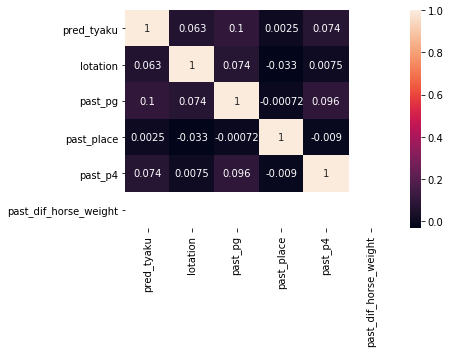

In [414]:
#heat_mapを確認
cols = ['pred_tyaku', 'lotation', 'past_pg', 'past_place', 'past_p4','past_dif_horse_weight']
cm = np.corrcoef(df_past1[cols].values.T)
sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols,xticklabels=cols)

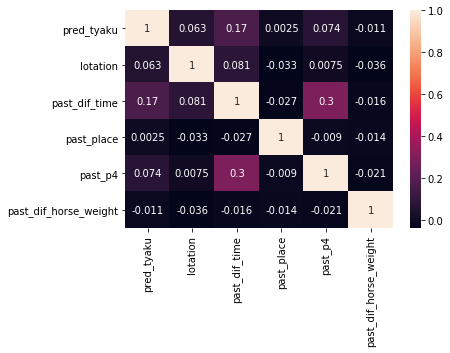

In [408]:
cm = df_past1[cols].corr().values
sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols,xticklabels=cols)

In [391]:
df_past1.past_dif_time

0          1.3
2          1.8
10         2.2
14         1.4
18         1.4
          ... 
1012559    0.3
1012571    1.3
1012581    1.5
1012588    0.4
1012604    0.6
Name: past_dif_time, Length: 139795, dtype: float64

In [1]:
from google.cloud import storage

In [7]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/home/h-kobayashi/nth-computing-270722-763ccf51011e.json'
project_id = "nth-computing-270722"
client = storage.Client(project_id)

In [16]:
blobs =  client.list_blobs("model1",prefix='model/model1')

In [17]:
for blob in blobs:
    bucket = blob.bucket
    blob = bucket.get_blob(blob.name)
    print(blob.name)

model/model1/model0.pickle
model/model1/model1.pickle
model/model1/model2.pickle
model/model1/model3.pickle
model/model1/model4.pickle
model/model1/model5.pickle
model/model1/model6.pickle
model/model1/model7.pickle
model/model1/model8.pickle
model/model1/model9.pickle
